# Decision-Making Based on Business Metrics

We will conduct an analysis of a large online store. Together with the marketing department, was prepared a list of hypotheses to increase revenue.

**Research Objectives**  
- Prioritize hypotheses  
- Perform and analyze A/B test results  

**Tasks Required for Analyzing A/B Test Results:**  
- Plot cumulative revenue by groups.  
- Plot cumulative average order value by groups.  
- Plot the relative difference in cumulative average order value between Group B and Group A.  
- Plot cumulative conversion rate by groups.  
- Plot the relative difference in cumulative conversion rate between Group B and Group A.  
- Create a scatter plot of the number of orders per user.  
- Calculate the 95th and 99th percentiles of orders per user to determine thresholds for identifying outlier users.  
- Create a scatter plot of order values.  
- Calculate the 95th and 99th percentiles of order values to set thresholds for identifying outlier orders.  
- Calculate the statistical significance of conversion differences between the groups based on "raw" data.  
- Calculate the statistical significance of differences in average order value between the groups based on "raw" data.  
- Calculate the statistical significance of conversion differences between the groups based on "cleaned" data.  
- Calculate the statistical significance of differences in average order value between the groups based on "cleaned" data.  
- Draw conclusions and make assumptions.

**Data Description**  

**Data for Part One**  

**File /datasets/hypothesis.csv**  
- `Hypothesis` — brief description of the hypothesis;  
- `Reach` — user reach on a scale of 1 to 10;  
- `Impact` — impact on users on a scale of 1 to 10;  
- `Confidence` — confidence in the hypothesis on a scale of 1 to 10;  
- `Efforts` — resources required to test the hypothesis on a scale of 1 to 10. The higher the Efforts value, the more expensive the hypothesis testing.  

**Data for Part Two**  

**File /datasets/orders.csv**  
- `transactionId` — order ID;  
- `visitorId` — ID of the user who placed the order;  
- `date` — date the order was placed;  
- `revenue` — order revenue;  
- `group` — A/B test group to which the order belongs.  

**File /datasets/visitors.csv**  
- `date` — date;  
- `group` — A/B test group;  
- `visitors` — number of users on the specified date in the specified A/B test group.

## Data preprocessing

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats as st
import numpy as np 
import datetime as dt

In [2]:
# read dataframes
hypothesis = pd.read_csv('/Users/a1/Downloads/hypothesis.csv')
orders = pd.read_csv('/Users/a1/Downloads/orders.csv')
visitors = pd.read_csv('/Users/a1/Downloads/visitors.csv')

**Consider the hypothesis table**

In [3]:
# look on the data
display(hypothesis.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [4]:
# general information
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [5]:
# check the number of duplicates
hypothesis.duplicated().sum()

0

There are no missing values and no duplicates in the table, the data type is correct for each column, but the column names are not written in accordance with the code style. Let's change the names

In [6]:
# change the case of the headers
hypothesis.columns = hypothesis.columns.str.lower()

**Consider the orders table**

In [7]:
# look on the table
display(orders.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
# general information
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
# check the number of duplicates
orders.duplicated().sum()

0

There are no missing values and no duplicates in the table, the data type is incorrect for the date column and the column names are not written in accordance with the code style. Change the data type and column names

In [10]:
# rename names of the columns 
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})
# change data type
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


**Consider the visitors table**

In [11]:
# look on the table
display(visitors.head())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [12]:
# general information
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [13]:
# check the number of duplicates
visitors.duplicated().sum()

0

There are no missing vaalues and no duplicates in the table, the data type is incorrect for the `date` column. Change the data type

In [14]:
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


We have reviewed all the tables and performed data preprocessing. Then start prioritizing hypotheses.

## Prioritization of hypotheses

The file `/datasets/hypothesis.csv` contains 9 hypotheses for increasing the revenue of an online store with the specified parameters Reach, Impact, Confidence, Effort.

Let's use the ICE framework to prioritize hypotheses. Sort them in descending order of priority.

In [15]:
# perform prioritization by ICE
hypothesis['ICE'] = (hypothesis['impact'] *  hypothesis['confidence']) / hypothesis['efforts']
hypothesis = hypothesis.sort_values(by='ICE', ascending=False)

# set the maximum column width
pd.set_option('display.max_colwidth', None)

display(hypothesis)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


The most promising hypotheses based on the ICE score are those with indices 8, 0, and 7.

Use the RICE framework to prioritize hypotheses. Sort them in descending order of priority.

In [16]:
# perform prioritization by RICE
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] *  hypothesis['confidence']) / hypothesis['efforts']
hypothesis = hypothesis.sort_values(by='RICE', ascending=False)
display(hypothesis) 

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


The most promising hypotheses based on the RICE score are those with indices 7, 2, and 0.

**Conclusion**  
After considering the number of users impacted by each hypothesis, the priority of the hypotheses changed. Hypothesis 7 became the most promising due to its broad reach, which allows it to affect the largest number of users.

## Analysis of the A/B test

Check if the users of one group are in another.

In [17]:
# find users who fall into both groups
overlapping_users = orders.groupby('visitor_id')['group'].nunique()
overlapping_users = overlapping_users[overlapping_users > 1].index

# count the number of such users
overlapping_count = len(overlapping_users)
overlapping_count

58

58 users fell into both groups.  
See how many users there are in each group in total

In [18]:
# determine the total number of users in each group
total_users_per_group = orders.groupby('group')['visitor_id'].nunique()
total_users_per_group

group
A    503
B    586
Name: visitor_id, dtype: int64

Thus, approximately more than 10% of users belong to both groups, which is a significant percentage.

The `visitors` table contains cumulative data for both groups, including the "overlapping" users. Therefore, when calculating conversion rates, it wouldn’t be entirely correct to remove the overlapping users. However, for calculating the average order value, we only need the `orders` table, so in this case, we can remove the overlapping users. To facilitate this, we'll create a separate table that is cleared of overlapping users to use for average order value analysis in the A/B test.

In [19]:
# delete the users who fall into both groups and save them to a new table
cleaned_orders = orders[~orders['visitor_id'].isin(overlapping_users)]

### To build graphs, we need to collect cumulative data.  
Create an array of unique pairs of date values and test groups using the drop_duplicates() method:

In [20]:
# create an array of unique pairs of date values and test groups
dates_groups = orders[['date','group']].drop_duplicates() 

Get rows from the orders table whose date is less than or equal to the date of the element from dates_groups, and the test group is equal to the group from dates_groups. And aggregate the data

In [21]:
# collect aggregated cumulative data on orders by day
orders_aggregated = dates_groups.apply(
                    lambda x: orders[
                        np.logical_and(
                        orders['date'] <= x['date'], orders['group'] == x['group']
                        )
                    ].agg(
                          {
                           'date': 'max',
                           'group': 'max',
                           'transaction_id': 'nunique',
                           'visitor_id': 'nunique',
                           'revenue': 'sum'
                          }
                    ), 
                     axis=1
                    ).sort_values(by=['date', 'group'])

display(orders_aggregated.head())

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Similarly, get aggregated cumulative data on visitors by day

In [22]:
# collect aggregated cumulative data on visitors by day
visitors_aggregated = dates_groups.apply(
                    lambda x: visitors[
                        np.logical_and(
                        visitors['date'] <= x['date'], visitors['group'] == x['group']
                        )
                    ].agg(
                          {
                           'date': 'max', 
                           'group': 'max', 
                           'visitors': 'sum'
                          }
                    ), 
                     axis=1
                    ).sort_values(by=['date', 'group'])

display(visitors_aggregated.head())

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Combine both tables into one with clear column names

In [23]:
# combine the cumulative data in one table and assign understandable names to its columns
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulative_data.head()) 

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


### Build graphs of cumulative revenue by groups

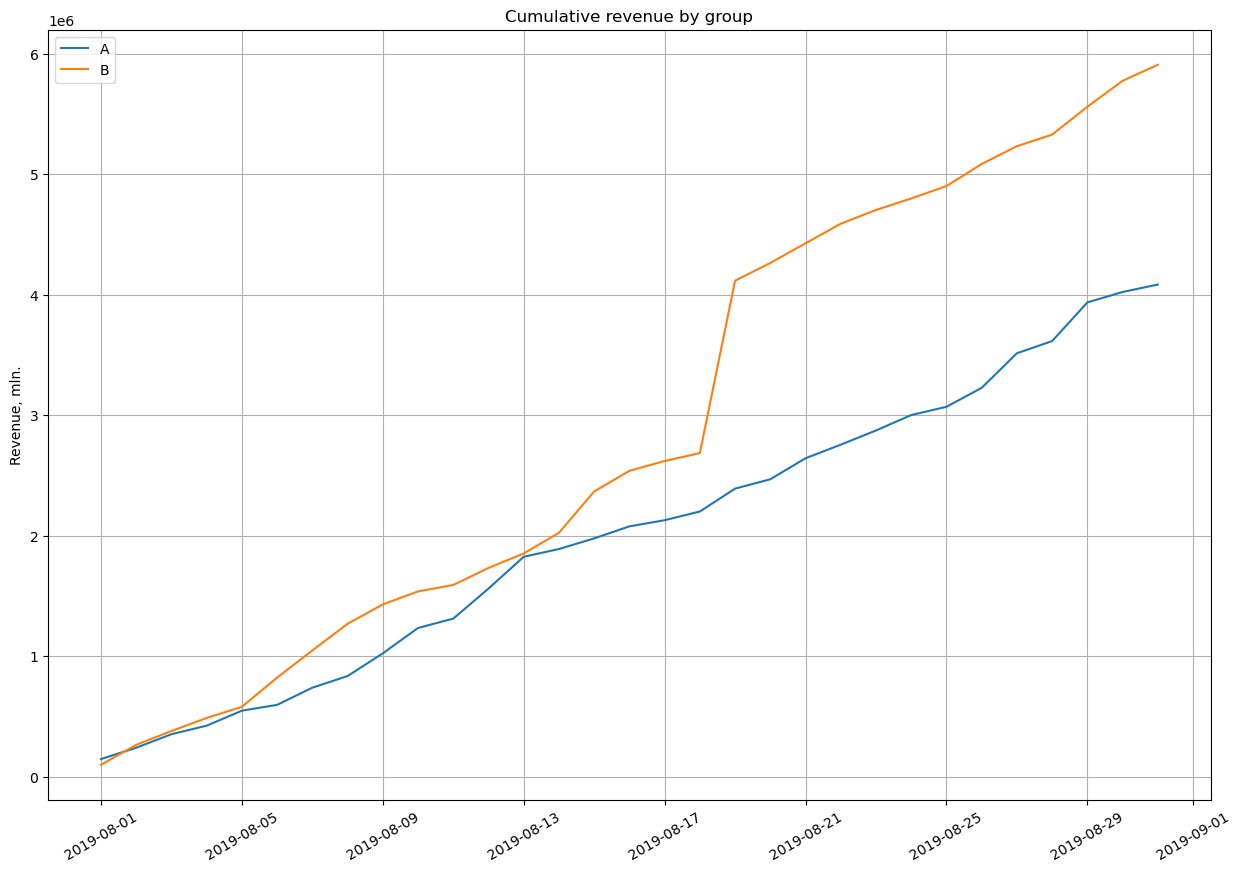

In [24]:
# a dataframe with cumulative number of orders and cumulative revenue by day in Group A
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# a dataframe with cumulative number of orders and cumulative revenue by day in Group B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# set the size of the graph
plt.figure(figsize=(15, 10))

# build the graph of the group A revenue
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# build the graph of the group B revenue
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.title('Cumulative revenue by group')
plt.ylabel("Revenue, mln.")
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()
plt.show()

Revenue increases almost uniformly throughout the test, with the exception of revenue in Group B, starting from August 18, 2019 to August 19, 2019. There were probably large purchases made during this period.  
In general, the revenue for Group A is less than for Group B.

### Plot the cumulative average bill by groups

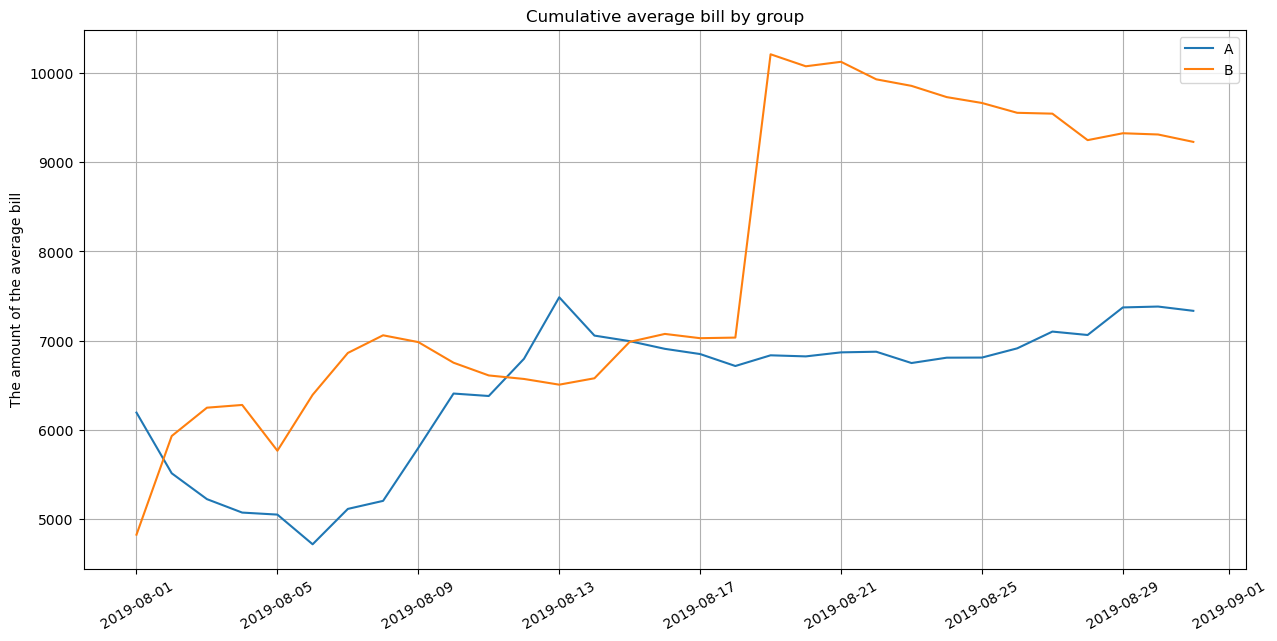

In [25]:
# set the size of the graph
plt.figure(figsize=(15, 7))

# divide the cumulative revenue by the cumulative number of orders
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], label='B')

plt.title('Cumulative average bill by group')
plt.ylabel("The amount of the average bill")
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()
plt.show()

The average bill for Group A stabilizes toward the end of the test after August 13, 2019.  

In Group B, however, there is a noticeable spike from August 18 to August 19, 2019. This likely indicates that a high-value purchase was made during this period.

### Plot the relative change in the cumulative average bill of group B to group A

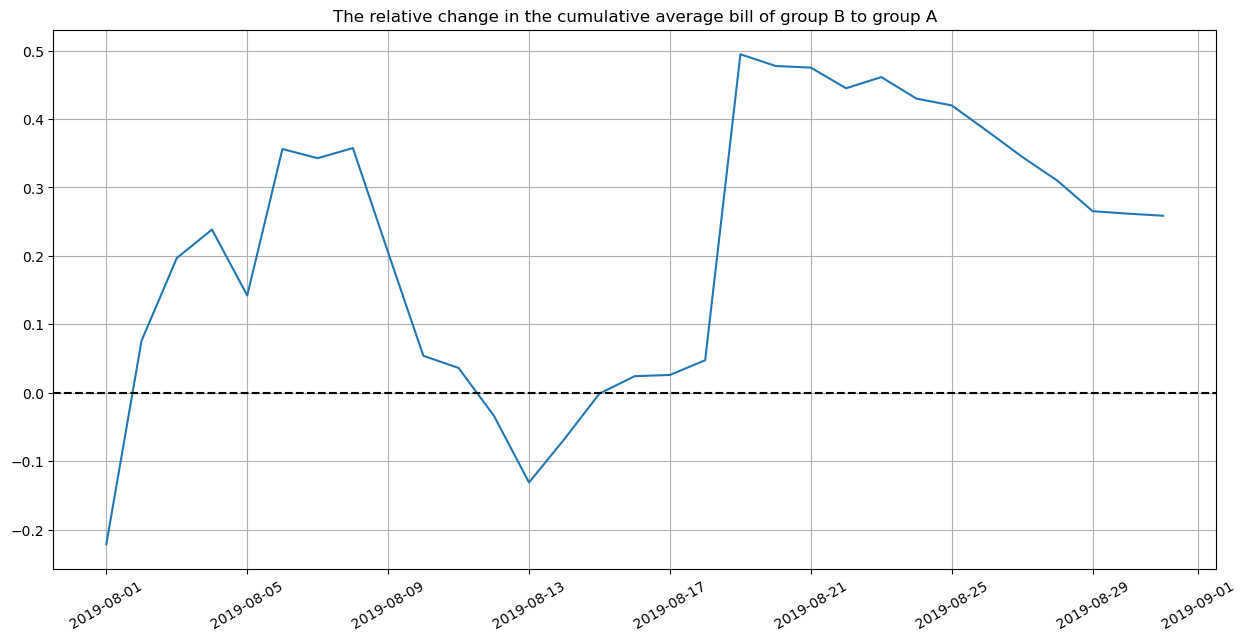

In [26]:
# collect data in a one dataframe
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', 
                                                                             right_on='date', 
                                                                             how='left', 
                                                                             suffixes=['_a', '_b'])
# set the size of the graph
plt.figure(figsize=(15, 7))

# build the ratio of average bills
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b'])/
                                            (merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['orders_a'])-1)

# add axhline
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('The relative change in the cumulative average bill of group B to group A')
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

At several points, the graph of the difference between the segments "jumps" sharply, which means there are outliers or large orders.

### Plot the cumulative average number of orders per visitor by group

Calculate the conversion values for the cumulative_data table

In [27]:
# add a column with conversion values
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

cumulative_data.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


In [28]:
# separate the data by group A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# separate the data by group B 
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

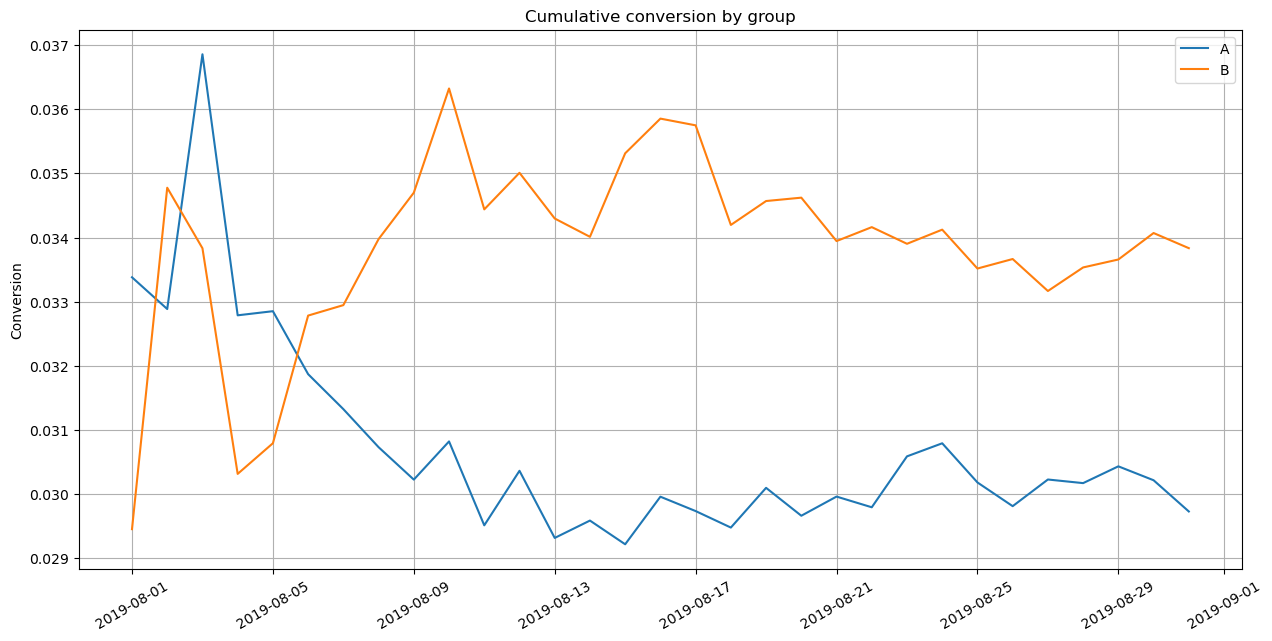

In [29]:
# set the size of the graph
plt.figure(figsize=(15, 7))

# build graphs
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')

plt.title('Cumulative conversion by group')
plt.ylabel('Conversion')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()
plt.show()

In the first days of the test, there were "jumps' in conversions, but starting from August 6, 2019, the conversion of group A fell sharply, and the conversion of group B increased. Before the end of the test, the conversion of group B exceeds the conversion of group A.

### Plot the relative change in the cumulative average number of orders per visitor of group B to group A

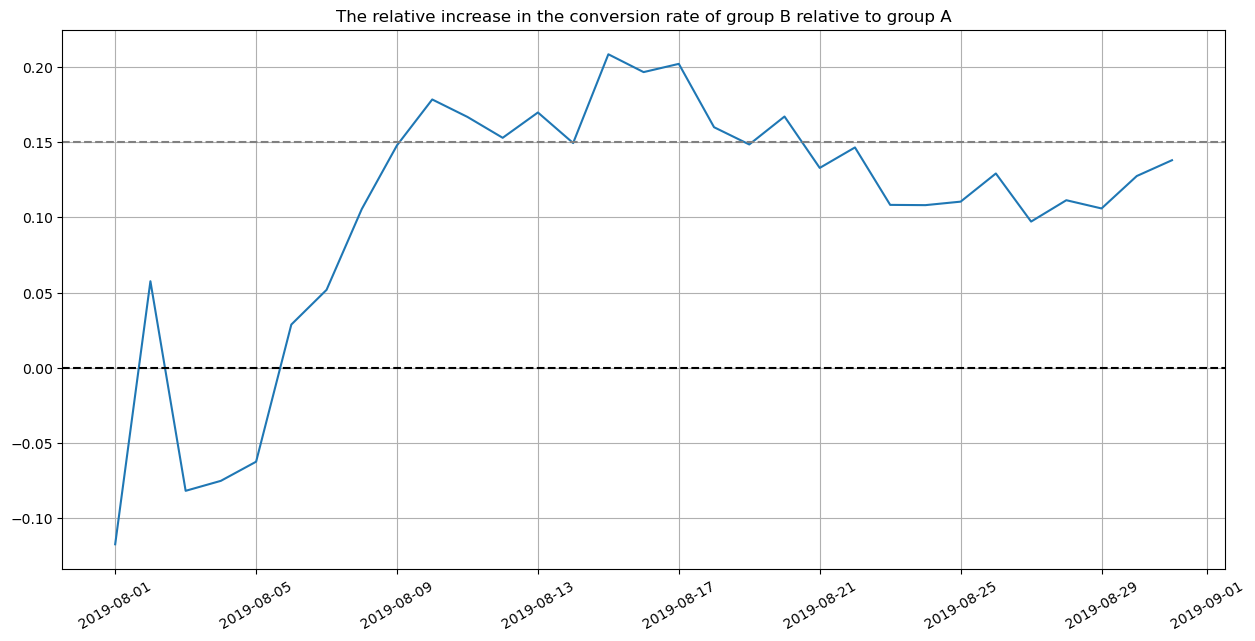

In [30]:
# collect data in a one dataframe
merged_cumulative_conversions = cumulative_data_a[['date', 'conversion']].merge(
                                       cumulative_data_b[['date', 'conversion']], 
                                       left_on='date', 
                                       right_on='date', 
                                       how='left', 
                                       suffixes=['_a', '_b'])
    
# set the size of the graph
plt.figure(figsize=(15, 7))

# plot the relative change in the cumulative conversion of group B to group A
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversion_b']/
                                                merged_cumulative_conversions['conversion_a']-1)

# aadd axhlines
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')

plt.title("The relative increase in the conversion rate of group B relative to group A")
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

Starting on August 6, the conversion difference between group B and group A began to increase sharply and strongly, from August 17 there was a slight decline, and from August 29 the difference increased again

### Build a scatter graph of the number of orders by user

Let's count the number of orders by users and look at the result

In [31]:
# calculate the number of orders for each user
orders_by_users = (orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'}))

# rename columns
orders_by_users.columns = ['visitor_id', 'orders']

# sort the number of orders in descending order
orders_by_users = orders_by_users.sort_values(by='orders', ascending=False)

orders_by_users.head()

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


Build a histogram of the distribution of the number of orders per user

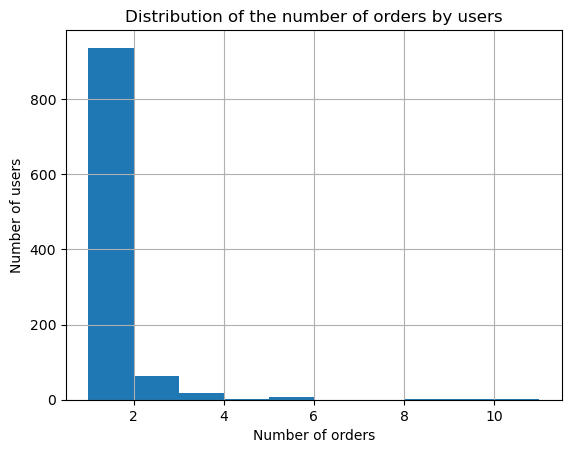

In [32]:
# build a histogram
plt.hist(orders_by_users['orders'])
plt.title('Distribution of the number of orders by users')
plt.xlabel('Number of orders')
plt.ylabel('Number of users')
plt.grid(True)
plt.show()

Most users took only one order

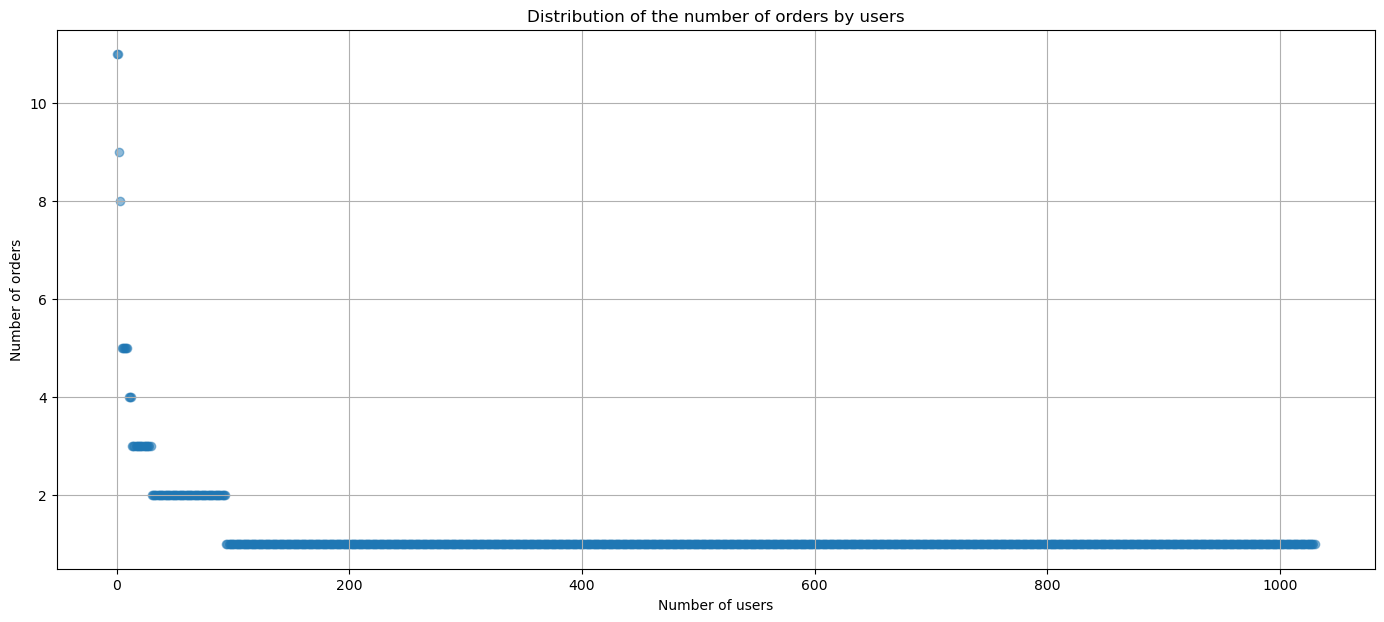

In [33]:
x_values = pd.Series(range(0,len(orders_by_users)))

# build a scatter chart of the number of orders per user
plt.figure(figsize=(17,7))
plt.scatter(x_values, orders_by_users['orders'], alpha=0.5)
plt.title('Distribution of the number of orders by users')
plt.xlabel('Number of users')
plt.ylabel('Number of orders')
plt.grid(True)
plt.show()

Most users most often take only one order, rarely 2 orders, and even less often - more than 2 orders

### Calculate the 95th and 99th percentiles of the number of orders per user

In [34]:
# calculate the sample percentiles of the number of orders per user
print(np.percentile(orders_by_users['orders'], [95, 99]))

[2. 4.]


No more than 5% of users took more than 2 orders. And 1% of users ordered more than 4 times. 
It is reasonable to select 4 orders per user for the upper limit of the number of orders, and weed out abnormal users according to it.

### Build a scatter chart of the cost of orders

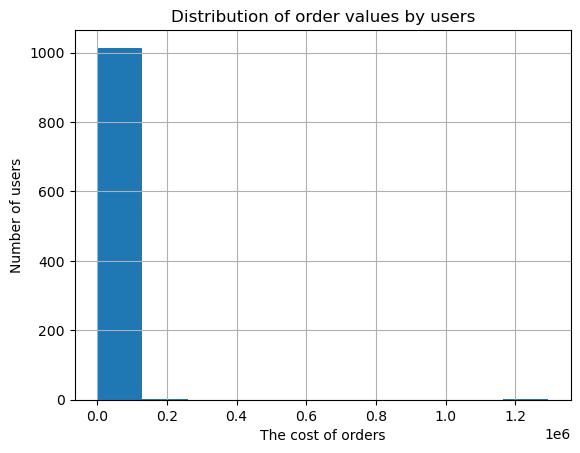

In [35]:
# build histogram
plt.hist(cleaned_orders['revenue'])
plt.title('Distribution of order values by users')
plt.xlabel('The cost of orders')
plt.ylabel('Number of users')
plt.grid(True)
plt.show()

There is even at least one order in the sample worth about 1.2 million rubles.

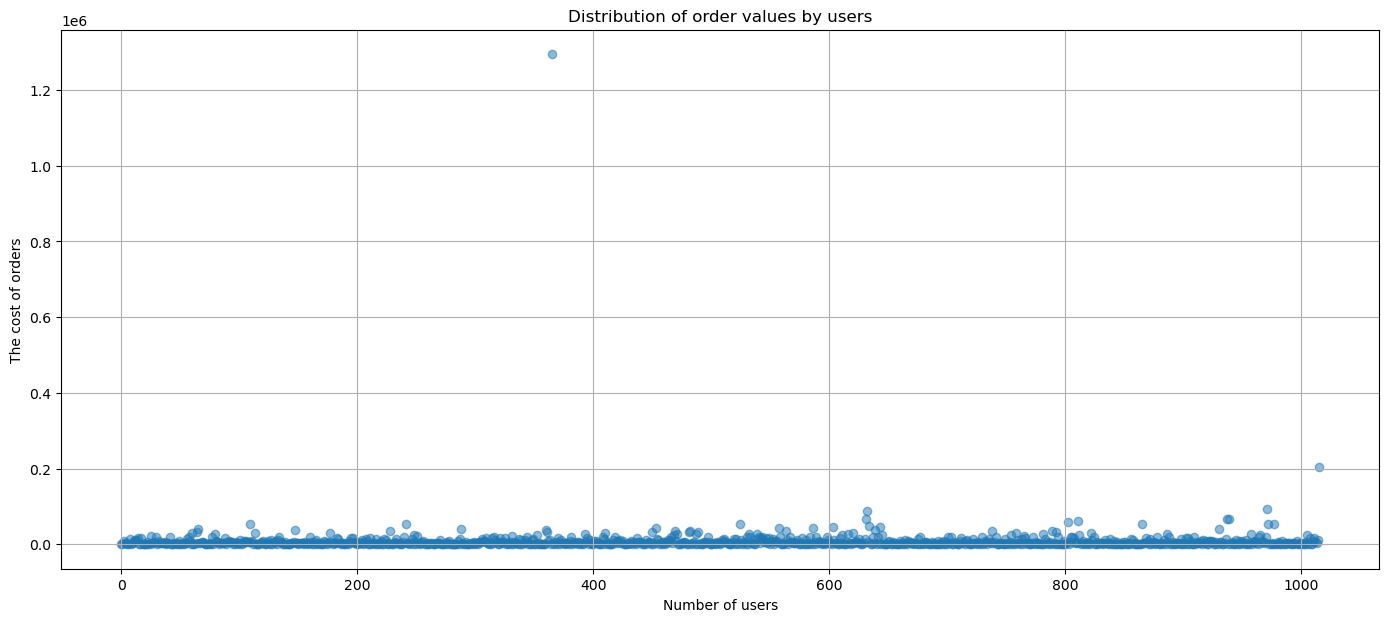

In [36]:
x_values = pd.Series(range(0,len(cleaned_orders['revenue'])))

# build a scatter chart of the cost of orders per user
plt.figure(figsize=(17,7))
plt.scatter(x_values, cleaned_orders['revenue'], alpha=0.5)
plt.title('Distribution of order values by users')
plt.xlabel('Number of users')
plt.ylabel('The cost of orders')
plt.grid(True)
plt.show()

We see a large abnormal value in the order value of more than 1.2 million rubles.

### Calculate the 95th and 99th percentiles of the cost of orders

In [37]:
# calculate the sample percentiles of the cost of orders per user
print(np.percentile(cleaned_orders['revenue'], [95, 99]))

[26785. 53904.]


No more than 5% of users took orders worth 26,785 rubles. And 1% of users placed orders worth more than 53,904 rubles. Let's take the cost of 53904 rubles. for the upper limit of the cost of orders, and weed out abnormal users according to it.

### Calculate the statistical significance of the differences in the average number of orders per visitor between the groups using the "raw" data

Let's formulate the hypotheses:  
**H0** - There is no difference in the average number of orders between the groups.  
**H1** - There is a difference in the average number of orders between the groups.

Set the significance level (alpha) to 0.05.

Start by preparing the data.

In [38]:
# create tables with the number of users in the context of groups and dates
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cumulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date':'max', 'visitors_per_date_a':'sum'}
    ),
    axis=1,
)
visitors_a_cumulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cumulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date':'max', 'visitors_per_date_b':'sum'}
    ),
    axis=1,
)
visitors_b_cumulative.columns = ['date', 'visitors_cummulative_b']


# create tables with the number of orders and revenue by groups and dates
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cumulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_a_cumulative.columns = ['date',
                               'orders_cummulative_a',
                               'revenue_cummulative_a']

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cumulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_b_cumulative.columns = ['date',
                               'orders_cummulative_b',
                               'revenue_cummulative_b']

# merge tables
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cumulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cumulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cumulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cumulative, left_on='date', right_on='date', how='left')
)

display(data.head())


,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Names of the colums:
- `date` — date
- `orders_daily_a` — number of orders on the selected date in group A
- `revenue_per_date_a` — total revenue on the selected date in group A
- `orders_daily_b` — number of orders on the selected date in group B
- `revenue_per_date_b` — total revenue on the selected date in group B
- `orders_cummulative_a` — cumulative number of orders up to and including the selected date in group A
- `revenue_cummulative_a` — cumulative revenue up to and including the selected date in group A
- `orders_cummulative_b` — cumulative number of orders up to and including the selected date in group B
- `revenue_cummulative_b` — cumulative revenue up to and including the selected date in group B
- `visitors_per_date_a` — number of visitors on the selected date in group A
- `visitors_per_date_b` — number of visitors on the selected date in group B
- `visitors_cummulative_a` — cumulative number of visitors up to and including the selected date in group A
- `visitors_cummulative_b` — cumulative number of visitors up to and including the selected date in group B

Calculate the statistical significance of the difference in the average number of orders between the groups.
Create the variables order_by_users_a and order_by_users_b.

In [39]:
# create tables with data on orders for each user
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

Declare the variables sample_a and sample_b, in which the number of orders will correspond to users from different groups. Those who have not ordered anything will be matched with zeros. This is necessary to prepare the samples for verification by the Mann-Whitney criterion.

In [40]:
# declare the variables
sample_a = pd.concat([orders_by_users_a['orders'],
                     pd.Series(0, index=np.arange(
                        data['visitors_per_date_a'].sum() - 
                        len(orders_by_users_a['orders'])),
                               name='orders')], axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],
                      pd.Series(0, index=np.arange(
                         data['visitors_per_date_b'].sum() - 
                         len(orders_by_users_b['orders'])),
                                name='orders')], axis=0) 

Apply the criterion and format the p-value, rounding it to three decimal places.  
We will also output the relative increase in the average number of orders of group B: the average number of orders of group B / the average number of orders of group A is 1. Round to three decimal places.

In [41]:
# find p-value
print("P-value: {0:.3f}".format(st.mannwhitneyu(sample_a, sample_b)[1]))

# deduce the relative increase in the average number of group B orders
print("Differences in the average number of orders per visitor: {0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

P-value: 0.017
Differences in the average number of orders per visitor: 0.138


The first number is p-value = 0.017 less than 0.05. Therefore, we reject the null hypothesis that there are no statistically significant differences in the average number of orders between the groups.  
However, the relative gain of group B is 13.8% — the second number in the output.

### Calculate the statistical significance of differences in the average bill between groups based on "raw" data

Let's formulate hypotheses:  
**H0** - there are no differences in the average bill between the groups  
**H1** - there are differences in the average bill between the groups  

Set the significance level alpha 0.05

Let's apply the criterion and format the p-value, rounding it to three decimal places.  
We will also output the relative increase in the average bill of group B: the average bill of group B / the average bill of group A is 1. Round to three decimal places.

In [42]:
# find p-value
print('P-value: {0:.3f}'.format(st.mannwhitneyu(cleaned_orders[cleaned_orders['group']=='A']['revenue'], 
                                          cleaned_orders[cleaned_orders['group']=='B']['revenue'])[1]))

# deduce the relative increase in the average check of group B
print('Differences in the average bill between groups: {0:.3f}'.format(cleaned_orders[cleaned_orders['group']=='B']['revenue'].mean()/
                       cleaned_orders[cleaned_orders['group']=='A']['revenue'].mean()-1)) 

P-value: 0.829
Differences in the average bill between groups: 0.287


The P-value is significantly higher than 0.05. Therefore, there is no reason to reject the null hypothesis and assume that there are differences in the average bill.  
At the same time, the average check of group B is 28.7% higher than the average bill of group B, but this difference is not statistically significant.

### Calculate the statistical significance of differences in the average number of orders per visitor between groups based on "cleared" data

Let's take as abnormal users those who have made at least 5 orders or made an order more expensive than 58233 rubles. This way we will remove 5% of users with the largest number of orders and from 1% to 5% of users with expensive orders.  
Let's make slices of users with more than 4 orders — users_with_many_orders and users who made orders more expensive than 58233 — users_with_expensive_orders. Let's combine them in the abnormal_users table.

Find out how many abnormal users there are with the shape attribute

In [43]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > np.percentile(orders_by_users['orders'], 99)]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > np.percentile(orders_by_users['orders'], 99)]['visitor_id']
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], 99)]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head())
abnormal_users.shape[0]

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64


15

There are 15 abnormal users in total.  
Let's find out how their actions affected the test results. Let's calculate the statistical significance of the differences in the average number of orders between the test groups based on the cleared data. First, we will prepare samples of the number of orders by users by test groups:

In [44]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Apply the Mann-Whitney statistical criterion to the obtained samples:

In [45]:
# find p-value
print('P-value: {0:.3f}'.format(st.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))

# deduce the relative increase in the average number of group B orders
print('Differences in the average number of orders per visitor: {0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

P-value: 0.014
Differences in the average number of orders per visitor: 0.153


The results for the average number of orders have not changed much. This means that we still reject the null hypothesis that there are no statistically significant differences in the average number of orders between the groups. 
The relative increase in the conversion rate of Group B increased to 15.3%.

### Calculate the statistical significance of the differences in the average bill between the groups based on the "cleared" data

In [46]:
print(
    '{0:.3f}'.format(
        st.mannwhitneyu(
            cleaned_orders[
                np.logical_and(
                    cleaned_orders['group'] == 'A',
                    np.logical_not(cleaned_orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            cleaned_orders[
                np.logical_and(
                    cleaned_orders['group'] == 'B',
                    np.logical_not(cleaned_orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        cleaned_orders[
            np.logical_and(
                cleaned_orders['group'] == 'B',
                np.logical_not(cleaned_orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / cleaned_orders[
            np.logical_and(
                cleaned_orders['group'] == 'A',
                np.logical_not(cleaned_orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.901
-0.032


The P-value has increased, which means it is still more than 0.05. Therefore, there is still no reason to reject the null hypothesis and assume that there are differences in the average check.  
But the average check of group B has not become much lower than the average check of group A, but this difference is not statistically significant.

## Conclusions

As part of this project, an analysis of a large online store was conducted.  
Data preprocessing was performed, hypotheses were prioritized, an A/B test was run, and results were obtained.

**In terms of hypothesis prioritization, the most promising hypotheses are:**  
1. Launch a promotion offering a discount on products on customers' birthdays  
2. Add two new traffic acquisition channels, which will increase user acquisition by 30%  
3. Add a subscription form to all main pages to build a customer database for email newsletters  

If the user reach is also considered for prioritizing hypotheses, the most promising hypotheses are as follows:  
1. Add a subscription form to all main pages to build a customer database for email newsletters  
2. Add product recommendation blocks to the online store’s website to increase conversion and average order value  
3. Add two new traffic acquisition channels, which will increase user acquisition by 30%  

**Results of the A/B test analysis:**  
- The hypothesis that there are no statistically significant differences in the average number of orders between the groups is rejected, both for "raw" and cleaned data. After removing anomalies, the conversion of group B is 15.3% higher than that of group A.  
- There is no statistically significant difference in the average check between the groups, neither for the "raw" data nor for the data after anomaly filtering. However, after removing anomalies, the average check for group B is slightly lower than for group A.  
- The relative change graph of the cumulative conversion of group B compared to group A shows that group B's results are consistently better than group A's.

**Based on the findings, the test should be stopped, and group B should be declared the winner.**